In [ ]:
import nltk
import string
# nltk.download('all')
import re
from nltk.corpus import stopwords
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM, Bidirectional
from keras.layers import Input, GlobalMaxPool1D, Dropout
from keras.layers import Activation
from keras.models import Model, Sequential
from keras import optimizers
from keras.utils.vis_utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("classification.csv")
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
#divide our training data into features X and label Y
X_train = train['sentence'] #will be used to train our model on
X_test = test['sentence'] #will be used to predict the output labels to see how well our model has trained
y_train = train[['Injury']].values
y_test = test[['Injury']].values

In [ ]:
y_train.shape

(1893, 1)

In [ ]:
punct = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~“”'

Clean Text

In [ ]:
def clean_text(txt):
  txt = txt.strip() #remove additional white space before and after end of sentence
  # txt = txt.lower()
  txt = txt.replace("'s", "") # remove apostrophe s
  txt = txt.replace("\?a.m.", "am") # replace a.m.
  txt = txt.replace("\?p.m.", "pm") # replace p.m.
  text = "".join([c for c in txt if c not in punct]) #remove punct
  text = text.replace(u'\u2014', "")
  new_text = text.replace(r"\s+", " ") #remove additional space

  return new_text

In [ ]:
#cleans train and test text  
x_train, x_test = [], []
for sentence in X_train:
  x_train.append(clean_text(sentence))

for sentence in X_test:
  x_test.append(clean_text(sentence))

In [ ]:
from keras.preprocessing.text import Tokenizer
#calculate the vocabulary size as well which will be given as an input to the Embedding layer
tokens = Tokenizer() 
tokens.fit_on_texts(x_train)
vocab_size = len(tokens.word_index) + 1 #size of the total number of uniques tokens in our dataset
tokenized_train = tokens.texts_to_sequences(x_train) #converting our tokens into sequence of integers
tokenized_test = tokens.texts_to_sequences(x_test)

In [ ]:
print(x_train[0]) #the first text
print(100 * '-')
print(tokenized_train[0]) #the correspondin first comment in the vectorized form

The incident happened at Balogu North a suburb of Yendi around 1830GMT on Monday August 31
----------------------------------------------------------------------------------------------------
[1, 98, 61, 10, 2298, 101, 2, 1487, 4, 1488, 35, 2299, 8, 47, 202, 436]


**Pad Sequences**

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len = 334 #max length of the padded sequence (one of the hyperparameter that can be tuned)
padded_train = pad_sequences(tokenized_train, maxlen = max_len, padding = 'post') #post padding our sequences with zeros
padded_test = pad_sequences(tokenized_test, maxlen = max_len)

In [ ]:
padded_train[:10]

array([[   1,   98,   61, ...,    0,    0,    0],
       [ 569,  235,    9, ...,    0,    0,    0],
       [   1,   81,  272, ...,    0,    0,    0],
       ...,
       [2305, 2306, 2307, ...,    0,    0,    0],
       [ 510,  472,  369, ...,    0,    0,    0],
       [ 569,  235,  223, ...,    0,    0,    0]], dtype=int32)

**GLOVE**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

embedding_dim = 50
#def create_embedding_matrix(filepath, embedding_dim):
vocab_size = len(tokens.word_index) + 1  # Adding again 1 because of reserved 0 index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open('/content/drive/MyDrive/FYP/glove.6B.50d.txt', encoding = 'utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokens.word_index:
            idx = tokens.word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False))
model1.add(LSTM(60, return_sequences = True))
model1.add(Activation('relu'))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.001))
model1.add(Dense(150, activation = 'relu'))
model1.add(Dropout(0.001))
model1.add(Dense(50, activation = 'relu'))
model1.add(Dropout(0.001))
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 334, 50)           249300    
_________________________________________________________________
lstm (LSTM)                  (None, 334, 60)           26640     
_________________________________________________________________
activation (Activation)      (None, 334, 60)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 150)               9150      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0

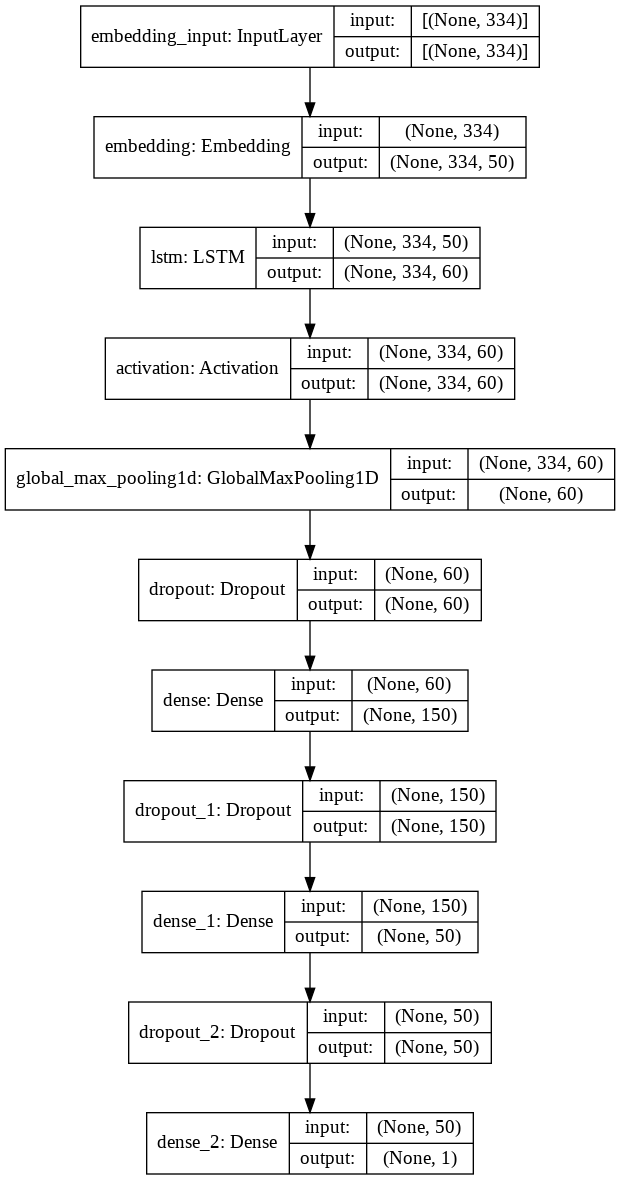

In [ ]:
# plot_model(model1, to_file='LSTM_Injury_Architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['acc'])
history1 = model1.fit(padded_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.1)

Epoch 1/4
107/107 [==============================] - 4s 19ms/step - loss: 0.6466 - acc: 0.5950 - val_loss: 0.4822 - val_acc: 0.8053
Epoch 2/4
107/107 [==============================] - 1s 12ms/step - loss: 0.4001 - acc: 0.8146 - val_loss: 0.2912 - val_acc: 0.8789
Epoch 3/4
107/107 [==============================] - 1s 12ms/step - loss: 0.2601 - acc: 0.8998 - val_loss: 0.2350 - val_acc: 0.9000
Epoch 4/4
107/107 [==============================] - 1s 12ms/step - loss: 0.2089 - acc: 0.9226 - val_loss: 0.2239 - val_acc: 0.9158


In [ ]:
max(history1.history['acc'])

0.9207281470298767

In [ ]:
max(history1.history['val_acc'])

0.9157894849777222

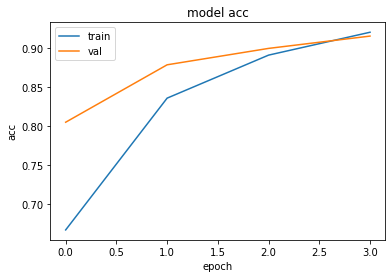

In [ ]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

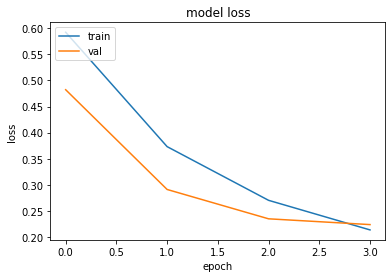

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model1.load_weights('/content/Injury_GloVe_LSTM_B16_Epoch4.h5')
model1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['acc'])

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(padded_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 30s 23ms/step - loss: 0.2826 - acc: 0.9118
test loss, test acc: [0.29430365562438965, 0.8957346081733704]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions1 = model1.predict(padded_test)
print("predictions shape:", predictions1.shape)
print("predictions shape:\n", predictions1[1:5])

Generate predictions for 3 samples
predictions shape: (211, 1)
predictions shape:
 [[0.96831626]
 [0.9754866 ]
 [0.09292302]
 [0.00187598]]


In [ ]:
y_test[1:5]

array([[1],
       [1],
       [0],
       [0]])

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

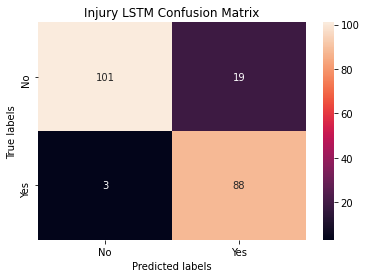

In [ ]:
cm = confusion_matrix(y_test, predictions1.round())
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Injury LSTM Confusion Matrix') 
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
print ("Batch Size: ", 16)
print ("LSTM Classification report: \n", (classification_report(y_test, predictions1.round())))

Batch Size:  16
LSTM Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.84      0.90       120
           1       0.82      0.97      0.89        91

    accuracy                           0.90       211
   macro avg       0.90      0.90      0.90       211
weighted avg       0.91      0.90      0.90       211



In [ ]:
# model1.save_weights('Injury_GloVe_LSTM_B16_Epoch4.h5')

**GLOVE - BILSTM**

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False))
model2.add(Bidirectional(LSTM(60, return_sequences = True)))
model2.add(Activation('relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.001))
model2.add(Dense(50, activation = 'relu'))
model2.add(Dropout(0.001))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 334, 50)           249300    
_________________________________________________________________
bidirectional (Bidirectional (None, 334, 120)          53280     
_________________________________________________________________
activation_1 (Activation)    (None, 334, 120)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)               

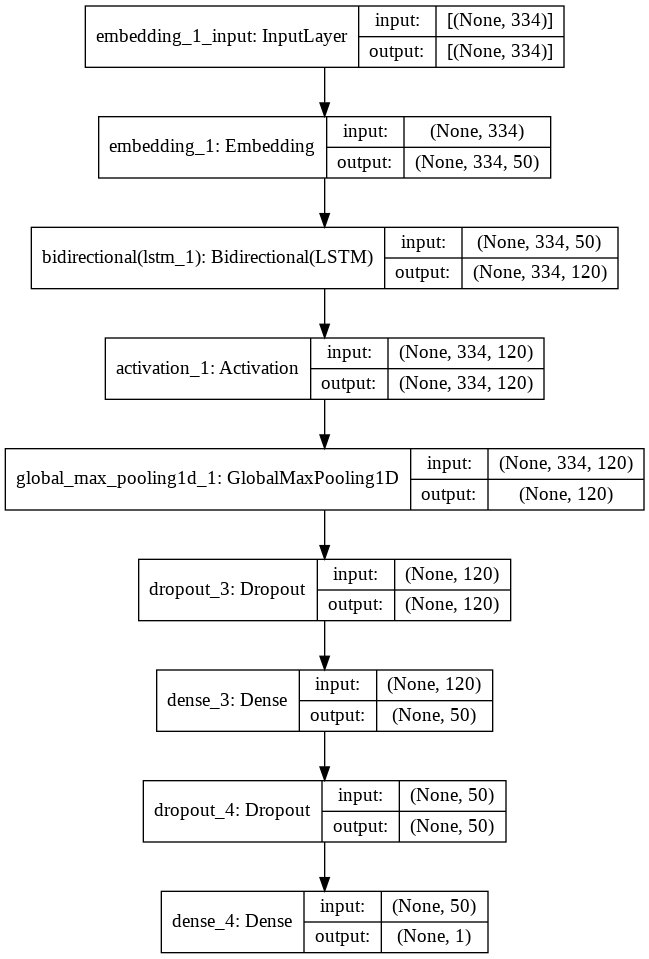

In [ ]:
# plot_model(model2, to_file='BILSTM_Injury_Architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['acc'])
history2 = model2.fit(padded_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.1)

Epoch 1/4
107/107 [==============================] - 6s 28ms/step - loss: 0.6064 - acc: 0.6833 - val_loss: 0.4188 - val_acc: 0.8000
Epoch 2/4
107/107 [==============================] - 2s 21ms/step - loss: 0.4073 - acc: 0.8106 - val_loss: 0.2939 - val_acc: 0.8789
Epoch 3/4
107/107 [==============================] - 2s 21ms/step - loss: 0.2965 - acc: 0.8864 - val_loss: 0.2327 - val_acc: 0.9158
Epoch 4/4
107/107 [==============================] - 2s 21ms/step - loss: 0.2415 - acc: 0.9106 - val_loss: 0.2093 - val_acc: 0.9158


In [ ]:
max(history2.history['acc'])

0.9154433608055115

In [ ]:
max(history2.history['val_acc'])

0.9157894849777222

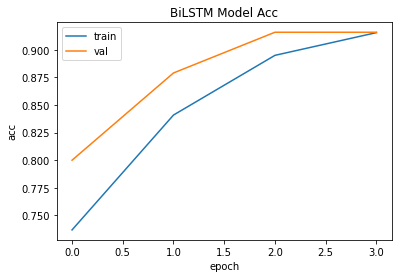

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('BiLSTM Model Acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

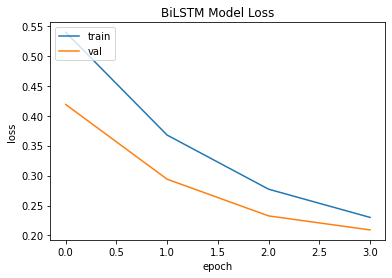

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('BiLSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model2.load_weights('/content/Injury_GloVe_BiLSTM_B16_Epoch4.h5')
model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['acc'])

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results2 = model2.evaluate(padded_test, y_test, batch_size=16)
print("test loss, test acc:", results2)

Evaluate on test data
14/14 [==============================] - 2s 45ms/step - loss: 0.2305 - acc: 0.9220
test loss, test acc: [0.2506074905395508, 0.9052132964134216]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions2 = model2.predict(padded_test)
print("predictions shape:", predictions2.shape)
print("predictions shape:\n", predictions2[:10])

Generate predictions for 3 samples
predictions shape: (211, 1)
predictions shape:
 [[0.14329034]
 [0.9752494 ]
 [0.95048434]
 [0.02465218]
 [0.00228379]
 [0.13248429]
 [0.10631397]
 [0.00203512]
 [0.9773079 ]
 [0.8169092 ]]


In [ ]:
y_test[:10]

array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

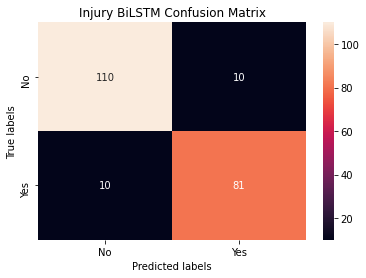

In [ ]:
cm = confusion_matrix(y_test, predictions2.round())
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.3g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Injury BiLSTM Confusion Matrix') 
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

In [ ]:
print ("Batch Size: ", 16)
print ("BiLSTM Classification report: \n", (classification_report(y_test, predictions2.round())))

Batch Size:  16
BiLSTM Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       120
           1       0.89      0.89      0.89        91

    accuracy                           0.91       211
   macro avg       0.90      0.90      0.90       211
weighted avg       0.91      0.91      0.91       211



In [ ]:
# model2.save_weights('Injury_GloVe_BiLSTM_B16_Epoch4.h5')